In [1]:
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray
import numpy as np
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline


class cudaCipher2:
    def __init__(self):
        """
        Attributes for instance of deviceAdd module
        Includes kernel code and input variables.
        """
        # If you are using any helper function to make 
        # blocksize or gridsize calculations, you may define them
        # here as lambda functions. 
        # Quick lambda function to calculate grid dimensions

        # Read the decipher text
        self.text_de = open('deciphertext.txt','r').read()
        self.length = len(self.text_de)
        
        # define block and grid dimensions
        self.blocksize = 256
        self.BlockDim = (self.blocksize,1,1)
        self.GridDim = (math.ceil(self.length/256),1,1)
        
        
        # kernel code wrapper
        self.kernelwrapper = """
        __global__
        void Decrypt(char *sentence, char *decrypted, int length){
            int i = blockIdx.x*blockDim.x + threadIdx.x;
            if(i<length){
                int asc = int(sentence[i]);
                if((asc > 96) && (asc < 123)){
                    if(asc < 110) decrypted[i] = char(asc+13);
                    else decrypted[i] = char(asc-13);
                    }
                else decrypted[i] = char(asc);
            }
        }
        """        

        # Compile the kernel code when an instance
        # of this class is made.
        self.mod = SourceModule(self.kernelwrapper)
    
    def devCipher(self, sentence):
        """
        Function to perform on-device parallel ROT-13 encrypt/decrypt
        by explicitly allocating device memory for host variables using
        gpuarray.
        Returns
            out                             :   encrypted/decrypted result
            time_ :   execution time in milliseconds
        """
        # create cuda events to record the execution time
        start_alc = cuda.Event()
        start_cpt = cuda.Event()
        end = cuda.Event()

        # Get kernel function
        func_dcp = self.mod.get_function("Decrypt")

        # Device memory allocation for input and output array(s)
            # convert string into np.chararaay
        sentence = np.char.asarray(sentence)
        decrypted = np.empty_like(sentence)
            # record execution time with memory allocation
        start_alc.record()
        sentence_d = gpuarray.to_gpu(sentence)
        decrypted_d = gpuarray.to_gpu(decrypted)

        # Record execution time and execute operation.
        start_cpt.record()
        func_dcp(sentence_d, decrypted_d, np.int32(self.length), block=self.BlockDim, grid=self.GridDim)
        end.record()
        
        # Wait for the event to complete
        end.synchronize()
        time_alc = start_alc.time_till(end)
        time_cpt = start_cpt.time_till(end)

        # Fetch result from device to host
        decrypted = decrypted_d.get()
        # Convert output array back to string

        return decrypted, time_alc

    
    def pyCipher(self, sentence):
        """
        Function to perform parallel ROT-13 encrypt/decrypt using 
        vanilla python.

        Returns
            decrypted                       :   encrypted/decrypted result
            time_         :   execution time in milliseconds
        """
        start = time.time()
        # using ord() convert sting to ascii whose datatype is int
        text_asc = [ord(i) for i in sentence]
        print(type(text_asc[1]))
        decrypted = ''
        # decrypt
        for asc in text_asc:

            if asc > 96 and asc < 123:
                if asc < 110:
                    # using chr() to convert ascii int to string
                    decrypted += chr(asc+13)
                else:
                    decrypted += chr(asc-13)
            else:
                decrypted += chr(asc)
        return decrypted, time.time()-start




In [125]:
cipher = cudaCipher2()
decrypted_py, time_py = cipher.pyCipher(cipher.text_de)
print(decrypted_py)

<class 'int'>
in the year 1878 i took my degree of doctor of medicine of the university of london, and proceeded to netley to go through the course prescribed for surgeons in the army. having completed my studies there, i was duly attached to the fifth northumberland fusiliers as assistant surgeon. the regiment was stationed in india at the time, and before i could join it, the second afghan war had broken out. on landing at bombay, i learned that my corps had advanced through the passes, and was already deep in the enemy's country. i followed, however, with many other officers who were in the same situation as myself, and succeeded in reaching candahar in safety, where i found my regiment, and at once entered upon my new duties. the campaign brought honours and promotion to many, but for me it had nothing but misfortune and disaster. i was removed from my brigade and attached to the berkshires, with whom i served at the fatal battle of maiwand. there i was struck on the shoulder by a 

In [124]:
# print(cipher.text_asc)
decrypted_dev,time_dev = cipher.devCipher(cipher.text_de)
print(time_dev,'\n',decrypted_dev)

0.7038400173187256 
 ["in the year 1878 i took my degree of doctor of medicine of the university of london, and proceeded to netley to go through the course prescribed for surgeons in the army. having completed my studies there, i was duly attached to the fifth northumberland fusiliers as assistant surgeon. the regiment was stationed in india at the time, and before i could join it, the second afghan war had broken out. on landing at bombay, i learned that my corps had advanced through the passes, and was already deep in the enemy's country. i followed, however, with many other officers who were in the same situation as myself, and succeeded in reaching candahar in safety, where i found my regiment, and at once entered upon my new duties. the campaign brought honours and promotion to many, but for me it had nothing but misfortune and disaster. i was removed from my brigade and attached to the berkshires, with "]


In [40]:
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray
import numpy as np
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
import sys

class cudaCipher:
    def __init__(self):
        """
        Attributes for instance of deviceAdd module
        Includes kernel code and input variables.
        """
        # If you are using any helper function to make 
        # blocksize or gridsize calculations, you may define them
        # here as lambda functions. 
        # Quick lambda function to calculate grid dimensions

        # define block and grid dimensions
        self.blocksize = 256
        self.BlockDim = (self.blocksize,1,1)
        # self.GridDim = (math.ceil(self.length/256),1,1)
        
        
        # kernel code wrapper
        self.kernelwrapper = """
        __global__
        void Decrypt(char *sentence, char *decrypted, int length){
            int i = blockIdx.x*blockDim.x + threadIdx.x;
            if(i<length){
                int asc = int(sentence[i]);
                if((asc > 96) && (asc < 123)){
                    if(asc < 110) decrypted[i] = char(asc+13);
                    else decrypted[i] = char(asc-13);
                    }
                else decrypted[i] = char(asc);
            }
        }
        """        

        # Compile the kernel code when an instance
        # of this class is made.
        self.mod = SourceModule(self.kernelwrapper)
    
    def devCipher(self, sentence):
        """
        Function to perform on-device parallel ROT-13 encrypt/decrypt
        by explicitly allocating device memory for host variables using
        gpuarray.
        Returns
            out                             :   encrypted/decrypted result
            time_ :   execution time in milliseconds
        """
        # create cuda events to record the execution time
        start_alc = cuda.Event()
        start_cpt = cuda.Event()
        end = cuda.Event()

        # Get kernel function
        func_dcp = self.mod.get_function("Decrypt")

        # culculate the gridDim
        # print(type(sentence))
        length = len(sentence)*sys.getsizeof(sentence)
        # print(length)
        GridDim = (math.ceil(length/self.blocksize),1,1)

        # Device memory allocation for input and output array(s)
            # convert string into np.chararaay
        sentence = np.char.asarray(sentence)
        # sentence = unicode(sentence, "utf-8") 
        decrypted = np.empty_like(sentence)
            # record execution time with memory allocation
        start_alc.record()
        sentence_d = gpuarray.to_gpu(sentence)
        decrypted_d = gpuarray.to_gpu(decrypted)
        # print(type(sentence))
        
        # Record execution time and execute operation.
        start_cpt.record()
        func_dcp(sentence_d, decrypted_d, np.int32(length), block=self.BlockDim, grid=GridDim)
        end.record()
        
        # Wait for the event to complete
        end.synchronize()
        time_alc = start_alc.time_till(end)
        time_cpt = start_cpt.time_till(end)

        # Fetch result from device to host
        decrypted = decrypted_d.get()
        # Convert output array back to string
        # decrypted = decrypted.decode('utf-8')
        # decrypted = literal_eval(sentence)
        # decrypted = str(decrypted)
        # print(type(decrypted))
        # decrypted = np.array2string(decrypted)
        decrypted = np.ndarray.tolist(decrypted)
        # print(type(decrypted))

        return decrypted, time_alc

    
    def pyCipher(self, sentence):
        """
        Function to perform parallel ROT-13 encrypt/decrypt using 
        vanilla python.

        Returns
            decrypted                       :   encrypted/decrypted result
            time_         :   execution time in milliseconds
        """
        start = time.time()
        # using ord() convert sting to ascii whose datatype is int
        text_asc = [ord(i) for i in sentence]
        decrypted = ''
        # decrypt
        for asc in text_asc:

            if asc > 96 and asc < 123:
                if asc < 110:
                    # using chr() to convert ascii int to string
                    decrypted += chr(asc+13)
                else:
                    decrypted += chr(asc-13)
            else:
                decrypted += chr(asc)
        # print(type(decrypted))
        return decrypted, time.time()-start

In [53]:
def main():
    # Main code
    # create a instance of cudaCipher
    cipher = cudaCipher()

    # Open text file to be deciphered.
    # Preprocess the file to separate sentences
    text_de = open('deciphertext.txt','r').read()

    # Split string into list populated with '.' as delimiter.
    sentences = text_de.split('. ')

    # Empty lists to hold deciphered sentences, execution times
    decrypted_c = []
    decrypted_p = []
    tc = []
    tp = []

    # Loop over each sentence in the list
    for sentence in sentences:
        temp_sc, temp_tc = cipher.devCipher(sentence)
        temp_sp, temp_tp = cipher.pyCipher(sentence)
        decrypted_c.append(temp_sc)
        decrypted_p.append(temp_sp)
        tc.append(temp_tc)
        tp.append(temp_tp)

    # post process the string(s) if required
    decrypted_cuda = []
    for sentence in decrypted_c:
        for i in sentence:
            a = i
        decrypted_cuda.append(a)

    tc = np.array(tc)
    tp = np.array(tp)

    # Execution time
    print("CUDA output cracked in ", tc.mean(), " milliseconds per sentence.")
    print("Python output cracked in ", tp.mean(), " milliseconds per sentence.")

    # check if the results match
    try:
        print("Checkpoint: Do python and kernel decryption match? Checking...")
        for i in range(len(decrypted_cuda)):
            # print(decrypted_cuda[i], decrypted_p[i])
            decrypted_cuda[i] += '. '
            decrypted_p[i] += '. '
            assert decrypted_cuda[i] == decrypted_p[i]
    # dump bad output to file for debugging
    except AssertionError:
        print('Checkpoint failed: Python and CUDA kernel decryption do not match. Try Again!')
    # If ciphers agree, proceed to write decrypted text to file and plot execution times
    else: 
        print("Checkpoint passed!")
        print("Writing decrypted text to file...")
        # Write cuda output to file
        decrypted_text = open('decrypted_text.txt', 'w')
        decrypted_text.write(''.join(decrypted_cuda))
        decrypted_text.close()
        # Dot plot the  per-sentence execution times
        plt.figure()
        plt.scatter(range(len(decrypted_cuda)), tc, label='pycuda')
        plt.scatter(range(len(decrypted_cuda)), tp, label='vanilla python')
        plt.legend()
        plt.grid()
        plt.title('Comparison of processing time (including memory allocation)')
        plt.xlabel('Sentences')
        plt.ylabel('Processing Time (ms)')
        # plt.show()
        plt.savefig('comparison.jpg')



CUDA output cracked in  0.4159970920194279  milliseconds per sentence.
Python output cracked in  5.959380756724965e-05  milliseconds per sentence.
Checkpoint: Do python and kernel decryption match? Checking...
Checkpoint passed!
Writing decrypted text to file...


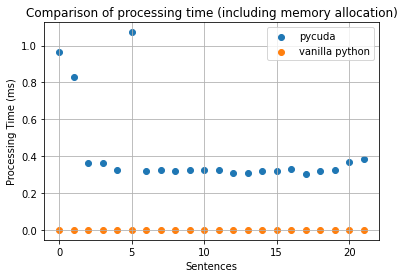

In [54]:
if __name__ == '__main__':
    main()